# Bootstrapping Improved

In the previous bootstrapping example, at each iteration, paths are simulated from $t=0$ to $t=nt$.
However, when at $\tau = t$, only the information from $t$ to $nt$ is used, the information from $0$ to $t$ is discarded.
To avoid wasting computer resources, we will make a light assumption.
From this point, we need to work with a Markovian dynamics model. Simply, a Markovian model for a stock price would mean that a stock price may fluctuate in a way where tomorrow’s price depends only on today’s price, not the entire history of movements.

We do this because for Markovian models, the optimal stopping time does not depend on the previous stock price, but only on the strike. 

Let $nt$ be the time step at maturity.
The optimal stopping time at time $\tau = t$ depends only on the strike, and not the entire path of $S$.
To determine the optimal stopping time at time $\tau = t$, we can start simulating at time $t$, up until $nt$.
From $nt-1$ to $t+1$, we apply the previously obtained optimal stopping time.

It is true that paths are still re-simulated from $t+1$ to $nt$, but the information is used. It is not completely wasted.


## Description of the process
- **forloop $\tau$ from nt to 0**
    - forloop irep from 0 to R-1
        - We prepare a tigth ISD around the exercise boundary at $\tau + 1$
        - We simulate from $\tau$ to $nt$
            - forloop t_now from nt to $\tau$
                - if $\tau$ < t_now
                    - We do not regress and instead apply the average beta for time t_now.
                - else
                    - We regress, store beta, and exit the loop
    - We take the average of betas for time $\tau$ over all repeats



## Reference
Létourneau, P., & Stentoft, L. (2019). Bootstrapping the early exercise boundary in the least-squares monte carlo method. Journal of Risk and Financial Management, 12(4), 190.


In [21]:
# Set the initial variables for the script
import numpy as np
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
import time

# Define parameters
r = 0.06    # Interest rate
K = 1.00    # Strike price
# it is better to work in time-steps than in years
dt = 1/12   # Time-step size in years
nt = 12     # Number of time-steps
T = nt*dt   # Total time to maturity in years

N = 1000      # Number of simulations
M = 5          # polynomial order for cross-sectional regressions
R = 100         # Number of repeats

# For the stock price, here, we will simulate from a Geometric Brownian motion
# We assume a risk-neutral measure
S0 = 1.00   # Initial stock price
sigma = 0.20  # Volatility of the stock


# For reproducibility when doing multiple repeats, we need to get multiple streams of random numbers. I need R streams
SEED = 42  # Seed for reproducibility
SEQ = np.random.SeedSequence(SEED)
SeedSeq = SEQ.spawn(R)
My_R_Streams = [np.random.default_rng(s) for s in SeedSeq]
# Store RNG states before simulation
rng_states = [rng.bit_generator.state for rng in My_R_Streams]
# Because we will loop over the repeats multiple times in the bootstrapping algorithm, 
# we will need to reset the stream each time to ensure we always simulte the same paths
# We don't really need this, though. We could just continue the simulate from the last point.
# However, if we wanted to test convergence as we add more repeats, we would need to reset the RNG state.

# initialize an array to store all average betas for the stopping time approximation
beta_st_average = np.zeros((M+1, nt))
previous_exec_lwbound = K
previous_exec_upbound = K
isd_size = 0.1  # Initial size of the ISD (Initial State Dispersion) region

start_time = time.time()
for t_boot in range(nt-1, 0, -1):
    # print(f"Bootstrapping iteration for t={t_boot}...")

    # Restore RNG states to re-simulate from the same point
    for i, rng in enumerate(My_R_Streams):
        rng.bit_generator.state = rng_states[i]
        
    beta_t_boot = np.zeros((M+1, R))  # Store beta coefficients for this bootstrapping iteration

    # loop over all repeats
    for repnum in range(R):
        # We need to clear variables in the loop to avoid carrying over values from previous iterations
        dcf = None
        intrinsic = None
        exec_t = None
        payoff = None
        
        # print(max(previous_exec_lwbound-isd_size, 0.1), previous_exec_upbound+isd_size)
        S = np.zeros((N, nt + 1))
        S[:, t_boot] = np.linspace(max(previous_exec_lwbound-isd_size, 0.1), previous_exec_upbound+isd_size, N)
        
        # print(S[:, t_boot:])

        for i in range(t_boot+1, nt + 1):
            Z = My_R_Streams[repnum].normal(0, 1, N)  # Standard normal random variables
            S[:, i] = S[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # print S but only from t_boot to maturity
        # print(S[:, t_boot:])


        # # We will create a new plot with the each siumulated path, from t_boot to maturity
        # plt.figure(figsize=(10, 6))
        # plt.plot(S[:, t_boot:], alpha=0.5)
        # plt.title(f'Simulated Stock Paths from t={t_boot} to Maturity')

        # We will calculate the exercise/intrinsic value for each path at maturity
        # recall that the option to price is a put option
        intrinsic = np.maximum(K - S[:,-1], 0)

        # We create a payoff vector that will contain the discounted exercise value.
        payoff = np.copy(intrinsic)

        # Now we set the vector exec_t to maturity for each path
        exec_t = nt * np.ones((N,), dtype=int)  # All paths would optimally be exercised at time-step 3 (so far))

        # We will do one more thing, for illustration purposes, we will keep the beta coefficients for each time-step in a matrix
        betas = np.zeros((3, nt))  # Store beta coefficients for each time-step

        for t_now in range(nt-1, t_boot-1, -1):

            # STEP 1
            dcf = np.exp(-r * dt) * payoff  # Discounted cash flow to time t

            # STEP 2
            itm_paths = np.where(S[:, t_now] < K)[0]  # Identify ITM paths

            # STEP 3
            # Build X matrix for regression (using the stock prices at time t_now)
            # We use a constant, the stock price and the square of the stock price
            x = S[itm_paths, t_now]
            X = np.ones((len(itm_paths), M + 1))
            for j in range(1, M + 1):
                X[:, j] = X[:, j - 1] * x

            # STEP 4
            # Build y vector (the discounted cash flows for ITM paths)
            y = dcf[itm_paths]

            # STEP 5
            # Perform regression to get beta coefficients
            if t_boot<t_now:
                # print(f"using previous beta average")
                # If we are not at the last bootstrapping iteration, we will use the average betas from the previous iteration
                beta = beta_st_average[:, t_now]

            else:
                # print(f"using lstsq to calculate new beta")
                # If we are at the last bootstrapping iteration, we will perform the regression
                # and store the beta coefficients for this time-step
                beta = lstsq(X, y, rcond=None)[0]
                beta_t_boot[:, repnum] = beta
                # now we can exit the loop and continue with the next repeat
                break

            # STEP 6
            # Calculate y_hat to approximate the holding value function
            y_hat = X @ beta

            # Update the payoff for exercised paths to be the current intrinsic value
            intrinsic[itm_paths] = np.maximum(K - S[itm_paths, t_now], 0)

            # STEP 7
            # Update the optimal exercise time for each path
            exec_t[itm_paths] = np.where(y_hat < intrinsic[itm_paths], t_now, exec_t[itm_paths])
            payoff = np.where(exec_t == t_now, intrinsic, dcf)
    
    # We can take the average of the beta coefficients across all repeats
    beta_st_average[:, t_boot] = np.mean(beta_t_boot, axis=1)

    # Update the previous execution bound for the next iteration
    # We will locate the max value of S[:, t_boot] that was exercised and min value of S[:, t_boot] that was not exercised
    exercised_paths = np.where(exec_t == t_boot)[0]
    # print(f"t_boot: {t_boot}, exercised paths: {len(exercised_paths)}")
    if len(exercised_paths) > 0:
        previous_exec_upbound = np.max(S[exercised_paths, t_boot])
    else:
        previous_exec_lwbound = np.min(S[:, t_boot])  # If no paths were exercised, use the min value
    
    # print(previous_exec_lwbound, previous_exec_upbound)

print(f"Time taken for bootstrapping: {time.time() - start_time:.2f} seconds")    

Time taken for bootstrapping: 0.63 seconds


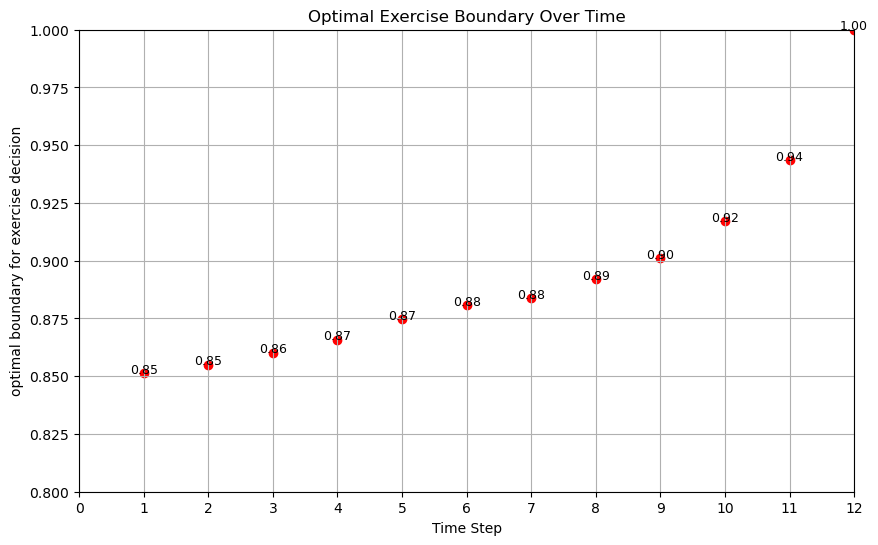

In [22]:
# Now, I want to loop through the betas and locate the intersection of the polynomial with the exercise value
# This will give use the optimal exercise boundary for this option

# For each time-step, beta defines a polynomial or second degree.
# The exercise value is polynomial of degree 1, so we can find the intersection points
import numpy.polynomial.polynomial as P
import matplotlib.pyplot as plt

# Define the exercise value polynomial coefficients
exercise_value_coeffs = [K, -1]  # Coefficients for the line y = K - x

# We will keep the intersection points for each time-step
intersection_points = []

# Loop through the betas and find the intersection points
for t in range(1, nt):
    # Get the beta coefficients for this time-step
    beta = beta_st_average[:, t]
    # print(f"\nTime-Step {t} Beta Coefficients:\n", np.array2string(beta, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # Define the polynomial for the option value
    option_value_poly = P.Polynomial(beta)
    option_execs_poly = P.Polynomial(exercise_value_coeffs)  # Second degree polynomial for the option value

    intersection = P.polyroots((option_value_poly - option_execs_poly).coef)
    # print(f"Intersection Points for Time-Step {t}:\n", np.array2string(intersection, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # I will only keep the intersection points where the x-coordinate is less than or equal to K
    intersection = intersection[intersection.real <= K]
    # If there are two intersection points, we will keep the one that is closest to K
    if len(intersection) > 1:
        intersection = intersection[np.abs(intersection - K).argmin()]
    elif len(intersection) == 0:
        intersection = np.array([])

    # Keep only the real roots
    intersection = intersection[intersection.imag == 0].real

    intersection_points.append(intersection)

# We know the optimal exercise at nt is at K, so we will append it to the intersection points
intersection_points.append(np.array([K]))

# Collect all valid intersection points and their time steps
x_vals = []
y_vals = []
for t, intersection in enumerate(intersection_points, start=1):
    if intersection.size > 0:
        x_vals.append(t)
        y_vals.append(intersection[0])

plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, color='red')
for t, y in zip(x_vals, y_vals):
    plt.text(t, y, f"{y:.2f}", fontsize=9, ha='center')
plt.ylim(0.8, 1)
plt.xlim(0, nt)
plt.xticks(np.arange(0, nt + 1, 1))
plt.xlabel('Time Step')
plt.ylabel('optimal boundary for exercise decision')
plt.title('Optimal Exercise Boundary Over Time')
plt.grid(True)
plt.show()

The new boundary is similar and took slightly less time to execute.

However, we can do better.
Since the ISD is not as large, we can get away with using a lower order polynomial.